In [1]:
import requests # necessary for accessing API
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, date, timedelta
import GetOldTweets3 as got # useful for accessing tweet history

# Elon's Tweet Effect on Tesla’s Stock Price - Technical Write Up

<img src="./images/gigafactory.jpg" align = 'left' alt="tingo" width="400"/>

### Google Slide Deck
https://docs.google.com/presentation/d/1gz360drOLdCrFkm2v27fgX88dSv8tpL5zlFuLv7dACg/

## Executive Summary:
On August 7th, 2018, Tesla CEO Elon Musk tweeted that had secured funding to take Tesla private at 420 dollars per share.  This price estimate was much higher than the price 341 dollars per share thus leading investors to drive up the price based on the assumption that the shares would be worth 420 dollars per share.

It was later revelaed that Musk may overstated his level certainty when it came to the buyout offer (which never materialized) which then lead the US Securities and Exchange Commission to investgate Musk for securities fraud.

The SEC, in a settlment with Musk agreed to have someone from Tesla monitor the CEO's tweets.  A subsequent settlement clarified the topics Musk was forbidden from tweeting about.

https://www.sec.gov/news/press-release/2018-226

https://www.washingtonpost.com/technology/2019/04/26/elon-musk-sec-resolve-dispute-over-teslas-ceos-tweets/

### Plan of Action:
Construct a model for the board of directors to assist in the tweet screening process, per the SEC settlment.
### Justification for Building NLP Model:
ELon Musk is notoriously difficult to manage and may not take well to being reigned in by the board. But we know that he likes science so if we prove to him that a tweet is too risky, he may be more likely to adhere the terms of the settlement.

### Problem Statement: Does Elon Musk's tweets be an accurate predictor of Tesla's stock price volatility and will build a model to predict the probability that a Musk tweet coincides with a 3 percent or more gain or loss in stock price.

### Data Source - Twitter & GetOldTweets Python Package
I used the Python package GetOldTweets to aquire tweet text from Elon Musk's twitter account. I extracted the date and text information and stored that data in a .csv file

In [2]:
# tweetCriteria = got.manager.TweetCriteria().setUsername("elonmusk").setMaxTweets(60000) # acquiring the tweets
# tweet = got.manager.TweetManager.getTweets(tweetCriteria)

In [3]:
# elon = []
# for i in range(len(tweet)):
   # dict = {}
   # dict['date'] = tweet[i].date
   # dict['tweet'] = tweet[i].text
    
   # elon.append(dict)

In [4]:
# elon_musk = pd.DataFrame(elon)
# elon_musk['date'] = elon_musk['date'].astype('str')
# elon_musk['date'] = elon_musk['date'].str[:10]
# elon_musk['date'] = pd.to_datetime(elon_musk['date'])
# elon_musk.to_csv('elon.csv', index = False)

### Data Source - Tiingo API
There's a great website for stock price information called https://www.tiingo.com/ that I used to aquire all of Tesla's stock price information.

In [5]:
#header for the API call
headers = {
    'Content-Type': 'application/json'
}

In [6]:
#setting up the parameters variables for the Tiingo API
start = str(pd.to_datetime(datetime.now() + timedelta(weeks = -15), format='%Y-%m-%d'))[:10] # setting up date range
stop = str(pd.to_datetime(datetime.today(), format='%Y-%m-%d'))[:10] # using [:10] to subset string
date_range = pd.date_range(start = start, end = stop) # date range

In [7]:
#grabbing the stock price information for Tiingo.com
tickers = 'tsla'
startDate = '2010-01-01'
endDate = stop
token = '7471448cb0d6ac0ee714d622d7cada65b28a552e'
url = str(f"https://api.tiingo.com/tiingo/daily/{tickers}/prices?&startDate={startDate}&endDate={endDate}&token={token}")

#this is an example of how to filter news story by ticker
requestResponse = requests.get(url,
                              headers=headers)

In [8]:
test_price = pd.DataFrame(requestResponse.json()) # requesting data

In [9]:
test_price['date'] = test_price['date'].str[:10]  # cleaning up data setting up proper date format
test_price['date'] = pd.to_datetime(test_price['date'], format='%Y-%m-%d')
test_price.set_index('date', inplace = True)

In [10]:
test_price.head() # data check

,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
date,,,,,,,,,,,,
2010-06-29,23.89,25.0000,17.54,19.00,18766300,23.89,25.0000,17.54,19.00,18766300,0.0,1.0
2010-06-30,23.83,30.4192,23.30,25.79,17187100,23.83,30.4192,23.30,25.79,17187100,0.0,1.0
2010-07-01,21.96,25.9200,20.27,25.00,8218800,21.96,25.9200,20.27,25.00,8218800,0.0,1.0
2010-07-02,19.20,23.1000,18.71,23.00,5139800,19.20,23.1000,18.71,23.00,5139800,0.0,1.0
2010-07-06,16.11,20.0000,15.83,20.00,6866900,16.11,20.0000,15.83,20.00,6866900,0.0,1.0


In [11]:
# creating target variable
test_price['vol'] = (abs((test_price['open']-test_price['close'])/test_price['open']) > 0.08).astype(int) 
test_price[['vol']].head() # data check

,vol
date,
2010-06-29,1
2010-06-30,0
2010-07-01,1
2010-07-02,1
2010-07-06,1


In [12]:
test_price.to_csv('price.csv', index = True)

# Merging & Formating Data Sources
Because grabbing the stock market data requires an API and because GetOldTweets takes a long time to run, I've decided to save the most recent pull into an external .csv file that I'll merge in the next step.

Other than that I didn't really have to do much data transformation. As you'll see before I did have to resample my time series data to get a dataset that was easier to map on a time series plot.

In [13]:
elon_musk = pd.read_csv('elon.csv')
test_price = pd.read_csv('price.csv')

In [14]:
elon_musk['date'] = pd.to_datetime(elon_musk['date'])
test_price['date'] = pd.to_datetime(test_price['date'])

In [15]:
df = pd.merge(elon_musk, # merging two data frames to create a data frame that has news items associated with whether or not the
              test_price, # S&P 500 went up or down that day
              how = 'inner', 
              left_on = 'date',
              right_on = 'date')[['date', 'tweet', 'vol']]
df['vol'].value_counts() # checking on class imbalance

0    5926
1     103
Name: vol, dtype: int64

In [16]:
# resampling the volatility data into a format that is easier to chart
resampled = test_price.set_index('date').resample('Q').mean()

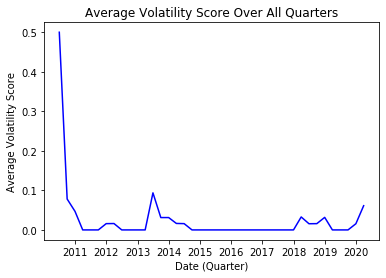

In [17]:
# my first crack at plotting out a so called volatility score
# volatility score is the average 0 to 1 binary classification
sns.lineplot(x = resampled.index, y = 'vol', data = resampled, color = 'blue')
plt.ylabel('Average Volatility Score')
plt.xlabel('Date (Quarter)')
plt.title('Average Volatility Score Over All Quarters');

In [18]:
elon_musk['date'] = pd.to_datetime(elon_musk['date'])
elon_musk = elon_musk.set_index('date')

In [19]:
tweet_graph = elon_musk.resample('Q').count()
tweet_graph.head()

,tweet
date,
2010-06-30,1
2010-09-30,0
2010-12-31,0
2011-03-31,0
2011-06-30,0


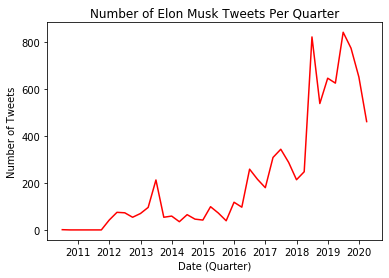

In [20]:
sns.lineplot(x = tweet_graph.index, y = 'tweet', data = tweet_graph, color = 'red')
plt.ylabel('Number of Tweets')
plt.xlabel('Date (Quarter)')
plt.title('Number of Elon Musk Tweets Per Quarter');

In [21]:
df.shape

(6029, 3)

In [22]:
# generating the correct value to rebalance the class
diff = df['vol'].value_counts()[0]-df['vol'].value_counts()[1]

# Model Selection
Justification: I decided to choose a binary classification model, (0 Tesla's stock price doesn't move less than 3 percent in one day or 1 Tesla's stock price does move more than 3 percent in one day) because I thought it would be a metric that would be easier to interpert and predict.

I chose the random forest classifier model because it's the one that performed the best while iterating through multiple models.

In [23]:
# import modling packages
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score,\
                            accuracy_score, precision_score, confusion_matrix, roc_auc_score, classification_report

In [24]:
# bootstrapping
gain = df[df['vol'] == 1]

bootstrap = gain.sample(n=diff, 
                           replace=True,
                           random_state=42
                           )
df = pd.concat([df, bootstrap])

In [25]:
df.shape

(11852, 3)

In [26]:
# setting up X and y variable
X = df['tweet'].astype(str) # can't explain why but this fixes an error caused when fitting the model
y = df['vol'].astype(np.int32)

In [27]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    random_state=29)

In [28]:
# pipeline
pipe = Pipeline([ 
    ('cvec', TfidfVectorizer(stop_words = 'english' )),
    ('rf', (RandomForestClassifier()))  # setting up pipeline
])

# Setting Up Hyper Parameters
There weren't too many hyper parameters for me to test. I iterated through multple selections of max features and ngrams before I landed on the current configuration.

In [29]:
# setting up parameters for grid search
pipe_params = {
    'cvec__max_features' : [4000], # pipe parameters
    'cvec__min_df' : [2],
    'cvec__max_df' : [0.9],
    'cvec__ngram_range' : [(1,2), (1,3)],
    'rf__n_estimators' : [10]
}

In [30]:
# grid search
gs = GridSearchCV(pipe,
                  pipe_params, # setting up grid search
                  cv = 5,
                  n_jobs = 8)

# And Let's Fit the Model

In [31]:
# fitting the model
gs.fit(X_train, y_train); # fitting the model

In [32]:
# getting the scores
print(f'Train score is {gs.score(X_train, y_train)}') # scoring
print(f'Test score is {gs.score(X_test, y_test)}')    # nice looks like there's no overfitting
print(f'Score diff is {gs.score(X_test, y_test) - gs.score(X_train, y_train)}')

Train score is 0.9667506297229219
Test score is 0.962678936605317
Score diff is -0.004071693117604913


#### Looks like the model performed fairly well considering the difficulty of the task.

In [33]:
proba = pd.DataFrame(gs.predict_proba(X_test))

In [34]:
tweet_screener = pd.merge(X_test, proba, how = 'inner', left_on = X_test.index, right_on = proba.index)[['tweet', 0, 1]]

In [35]:
tweet_screener.to_csv('tweet_screener.csv', index = False)
tweet_screener.rename(columns = {'tweet':'tweet', 0:'low_risk_tweet', 1:'risky_tweet'},inplace = True)

# Beta Testing the Predict Tweet Feature
Run the cell below and you'll see the predicted likelyhood that the tweet accurately predicted a swing of 3 percent in the stock price.

<img src="./images/wind.jpg" align = 'left' alt="tingo" width="400"/>

In [36]:
pd.set_option('display.max_colwidth', -1)
tweet_screener.sample()

C:\Users\onomi\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


,tweet,low_risk_tweet,risky_tweet
63,"Yeah, it looks like a medieval torture device, but is nonetheless currently used in many human studies! Not hard to be way better.",1.0,0.0


In [37]:
# what's the best parameters
gs.best_params_

{'cvec__max_df': 0.9,
 'cvec__max_features': 4000,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 3),
 'rf__n_estimators': 10}

In [38]:
# generating confusion matrix
predict = gs.predict(X_test)
confusion_matrix(y_test, predict)

pd.DataFrame(confusion_matrix(y_test, predict), # confusion matrix
             columns = ['predicted true', 'predicted false'],
             index = ['actual true', 'actual false'])

,predicted true,predicted false
actual true,1854,80
actual false,66,1912


In [39]:
# prep to generating the ROC score
predict = gs.predict(X_test)

In [40]:
pred_proba = [i[1] for i in gs.predict_proba(X_test)] # taken from the lesson classificaiton metrics ii
pred_df = pd.DataFrame({'true_values': y_test,  # because I honestly forgot how to do this all
                        'pred_probs':pred_proba})

In [41]:
# not too bad
roc_auc_score(pred_df['true_values'], pred_df['pred_probs'])

0.9946618072844724

# Preliminary Conclusions
Overall I'm fairly impressed with the model's ability to accurately predict a 3 percent swing in Telsa's stock price. Scientifically is it possible to say that X tweet caused y price jump or fall?  At a certain point a human on the board of directors should take over. 

With a few modifications this model can be applied to unseen Elon Musk tweets and provide a safety screen that the board could use as justification for nixing one of Musk's tweets that they already feel nervous about.

In [42]:
# classification report
print(classification_report(y_test, predict))

              precision    recall  f1-score   support

           0       0.97      0.96      0.96      1934
           1       0.96      0.97      0.96      1978

    accuracy                           0.96      3912
   macro avg       0.96      0.96      0.96      3912
weighted avg       0.96      0.96      0.96      3912



In [43]:
# setting up best estimator
cvec = gs.best_estimator_.named_steps['cvec']
fi = gs.best_estimator_.named_steps['rf'].feature_importances_ 

In [44]:
# prep for sparse dataframe
X_train_raw = cvec.fit_transform(X_train)

In [45]:
# sparse dataframe
X_train_sp = pd.DataFrame.sparse.from_spmatrix(X_train_raw, columns=cvec.get_feature_names()) 

In [46]:
# features dataframe
features_df = pd.DataFrame(fi, X_train_sp.columns, columns = ['importance'])

In [47]:
# plotting
barplot = features_df.sort_values(by = 'importance', ascending = False).head(10)

# Feature Importance
I would love to know why these words accurately predict a swing in Tesla's stock price.  Some of these words make sense but some of the predictive words seem vague.

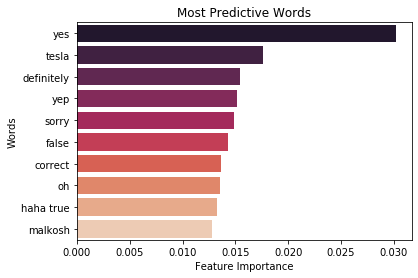

In [48]:
# most predicted words
sns.barplot(y = barplot.index, x = barplot['importance'], orient = 'h', palette="rocket")
plt.xlabel('Feature Importance')
plt.ylabel('Words')
plt.title('Most Predictive Words');